In [25]:
import datetime, os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow as tf

In [26]:
SEED = 8
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.1
IMAGE_SIZE = 224

In [27]:
img_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

In [28]:
train_ds = img_gen.flow_from_directory('E:\\SESH FOLDERS\\corn_dataset\\dataset_itr2\\dataset\\train',
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       shuffle=True, 
                                       seed=SEED,
                                       class_mode='sparse',
                                       batch_size=BATCH_SIZE,
                                       subset="training")

classes = list(train_ds.class_indices.keys())

print('Classes: '+str(classes))

num_classes  = len(classes)

Found 11100 images belonging to 4 classes.
Classes: ['Corn_(maize)___Common_rust_', 'Corn_(maize)___Gray_leaf_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy']


In [29]:
val_ds = img_gen.flow_from_directory('E:\\SESH FOLDERS\\corn_dataset\\dataset_itr2\\dataset\\train',
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       shuffle=False, 
                                       seed=SEED,
                                       class_mode='sparse',
                                       batch_size=BATCH_SIZE,
                                       subset="validation"
                                    )

Found 1232 images belonging to 4 classes.


In [30]:
test_ds = img_gen.flow_from_directory('E:\\SESH FOLDERS\\corn_dataset\\dataset_itr2\\dataset\\test',
                                      target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                      classes=['.'],
                                      class_mode= None,
                                      batch_size=BATCH_SIZE
                                    )

Found 3076 images belonging to 1 classes.


In [31]:
nb_train_samples = train_ds.samples
steps_per_epoch = nb_train_samples // BATCH_SIZE

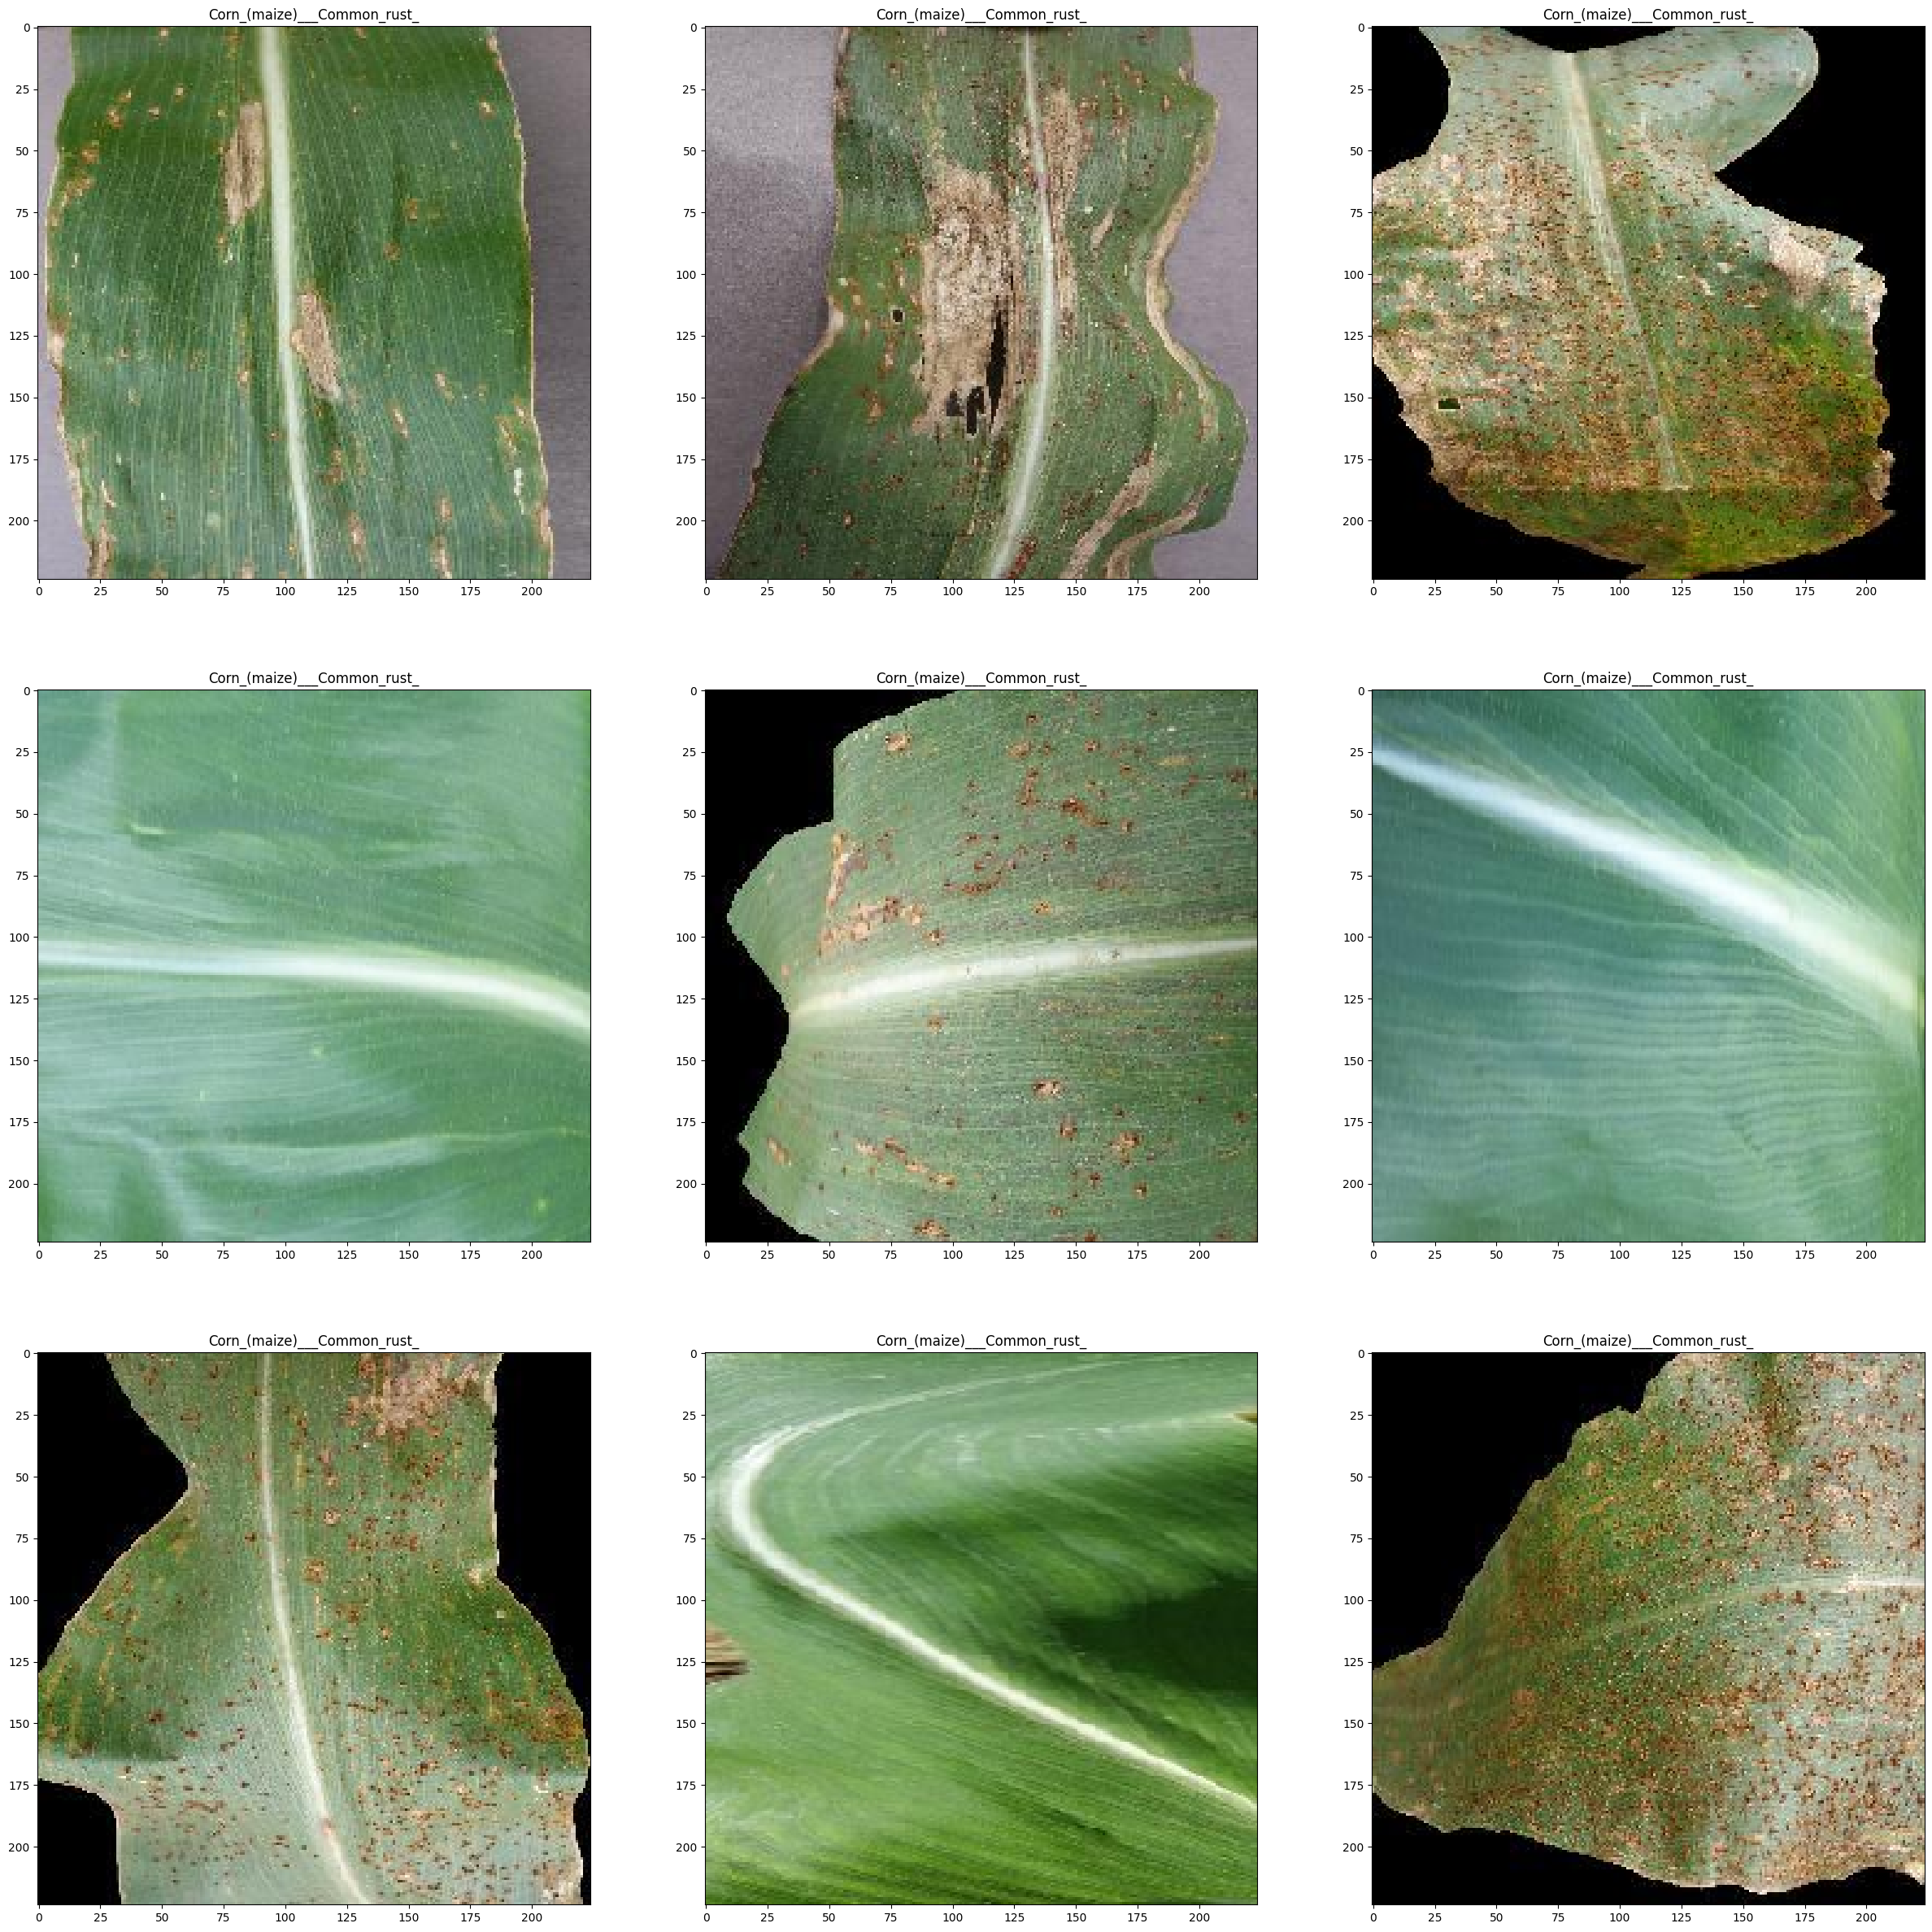

In [32]:
plt.figure(figsize=(30,30))
images = train_ds.next()*255
for i, (image, l) in enumerate(zip(images[0][:9],images[1][:9])):
    ax = plt.subplot(330 + 1 + i)
    ax.set_title( classes[np.argmax(l)] )
    plt.imshow(image)
plt.show()

In [48]:
model_densenet=DenseNet121(tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(num_classes, activation='softmax')
]))


model_densenet.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [49]:
history_densenet = model_densenet.fit(
    train_ds,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    validation_data = val_ds
)

model_densenet.summary()

Epoch 1/100
346/346 [==============================] - 21s 59ms/step - loss: 0.7711 - accuracy: 0.6887 - val_loss: 0.5698 - val_accuracy: 0.7597
Epoch 2/100
346/346 [==============================] - 16s 47ms/step - loss: 0.5119 - accuracy: 0.7821 - val_loss: 0.4777 - val_accuracy: 0.7922
Epoch 3/100
346/346 [==============================] - 16s 47ms/step - loss: 0.4997 - accuracy: 0.7810 - val_loss: 0.4725 - val_accuracy: 0.7987
Epoch 4/100
346/346 [==============================] - 16s 47ms/step - loss: 0.4931 - accuracy: 0.7837 - val_loss: 0.4665 - val_accuracy: 0.8052
Epoch 5/100
346/346 [==============================] - 16s 47ms/step - loss: 0.4887 - accuracy: 0.7863 - val_loss: 0.4803 - val_accuracy: 0.7987
Epoch 6/100
346/346 [==============================] - 16s 47ms/step - loss: 0.4851 - accuracy: 0.7872 - val_loss: 0.4537 - val_accuracy: 0.7922
Epoch 7/100
346/346 [==============================] - 16s 47ms/step - loss: 0.4770 - accuracy: 0.7883 - val_loss: 0.4803 - val_ac

In [50]:
scores_densenet = model_densenet.evaluate(val_ds)

39/39 [==============================] - 2s 42ms/step - loss: 0.4548 - accuracy: 0.8028


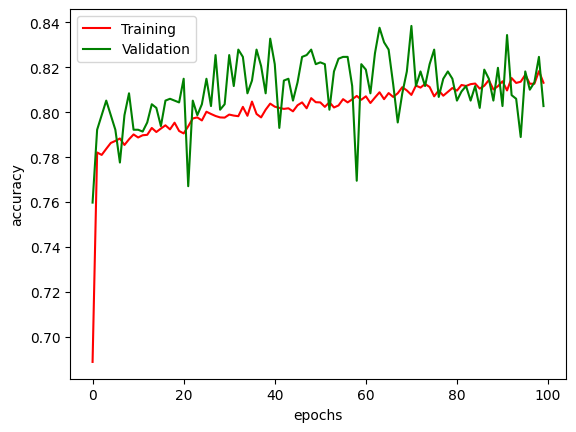

In [51]:
plt.plot(history_densenet.history["accuracy"], color="r")
plt.plot(history_densenet.history["val_accuracy"], color="g")
plt.legend(["Training", "Validation"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [52]:
predict = model_densenet.predict(test_ds, verbose=1)

97/97 [==============================] - 4s 42ms/step


In [53]:
predicted_class_indices = np.argmax(predict,axis=1)
print(set(predicted_class_indices))

inv_map = {v:k for k,v in train_ds.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3}


347/347 [==============================] - 37s 105ms/step
Confusion Matrix:
[[1088  210 1120 1017]
 [ 468   79  489  444]
 [ 899  148  913  877]
 [1041  179 1098 1030]]

Classification Report:
                                     precision    recall  f1-score   support

        Corn_(maize)___Common_rust_       0.31      0.32      0.31      3435
      Corn_(maize)___Gray_leaf_spot       0.13      0.05      0.08      1480
Corn_(maize)___Northern_Leaf_Blight       0.25      0.32      0.28      2837
             Corn_(maize)___healthy       0.31      0.31      0.31      3348

                           accuracy                           0.28     11100
                          macro avg       0.25      0.25      0.24     11100
                       weighted avg       0.27      0.28      0.27     11100



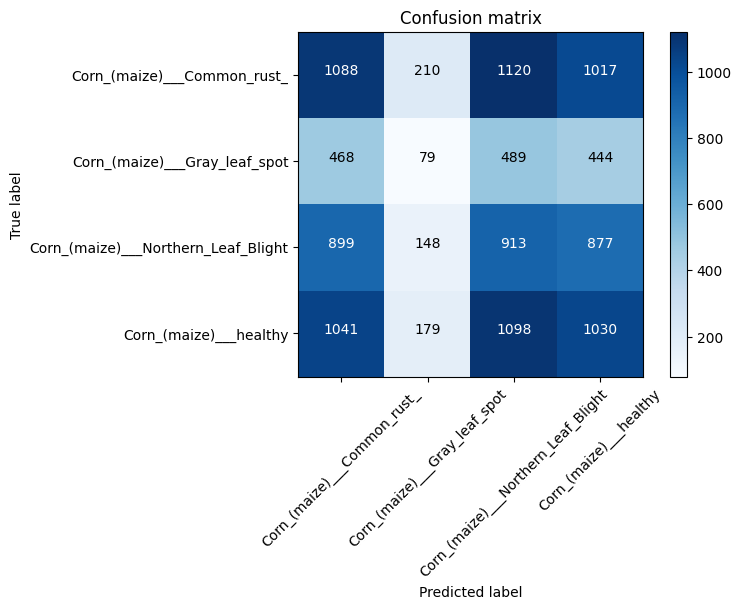

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Load your trained CNN model
#model = load_model('your_cnn_model.h5')

# Define a data generator for your test data
#test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load your test data using the data generator
# test_generator = test_datagen.flow_from_directory(
#     'C:/Users/smart/OneDrive/Documents/Mini Project/test_images',
#     target_size=(224, 224),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',  # Use 'binary' for binary classification
#     shuffle=False  # Set to True if you want to shuffle the test data
# )

# Make predictions on the test data
predictions = model_densenet.predict(train_ds, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = train_ds.classes

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes,predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# You can also plot the confusion matrix for better visualization
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fmt ='.2f' if normalize else 'd' 
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')                 
    plt.xlabel('Predicted label')

class_names = list(train_ds.class_indices.keys())
plot_confusion_matrix(confusion, classes=class_names)

# Print a classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))